# DAT200 CA5 2022

Kaggle username: dinussen27

### Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer as SI
from sklearn.preprocessing import OneHotEncoder 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer as II
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Reading data

In [24]:
df  = pd.read_pickle('train.pkl')
df= df.replace('missing', np.NaN)
df.head(4)
df = pd.get_dummies(df, drop_first = True, columns = ['Weather situation', 'Season'])
df.head(4)


df_test  = pd.read_pickle('test.pkl')
df_test = pd.get_dummies(df_test, drop_first = True, columns = ['Weather situation', 'Season'])


print(df.shape)
print(df_test.shape)



(12165, 17)
(5214, 16)


### Data exploration and visualisation

Year


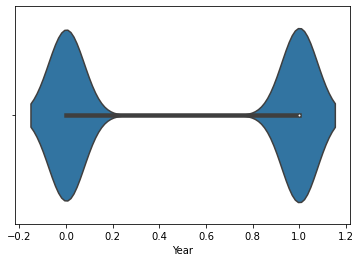

Month


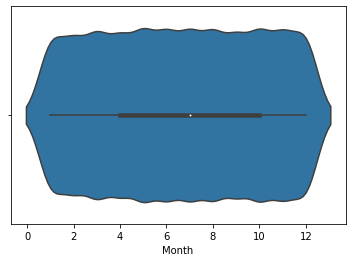

Hour


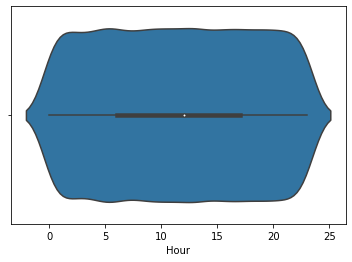

Holiday


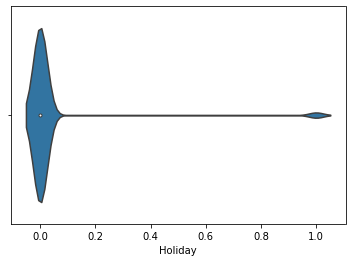

Weekday


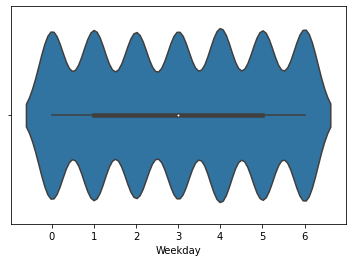

Working day


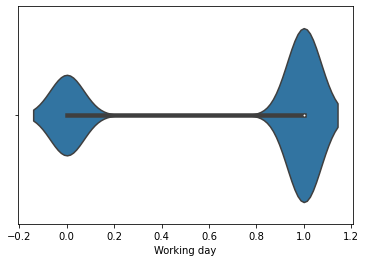

Temperature (normalized)


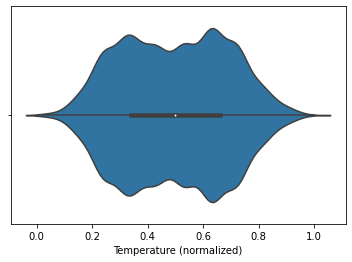

Feels-like temperature (normalized)


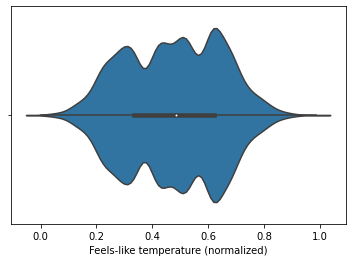

Humidity (normalized)


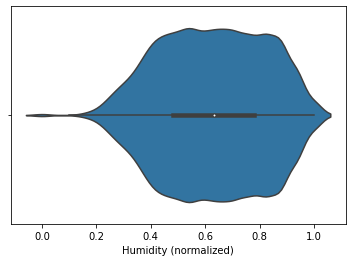

Windspeed


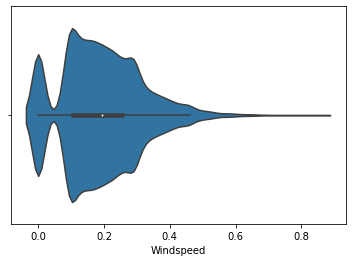

Rental bikes count


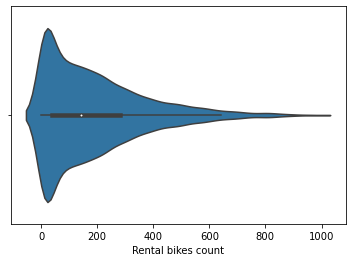

Weather situation_Heavy rain, heavy snow or thunderstorm


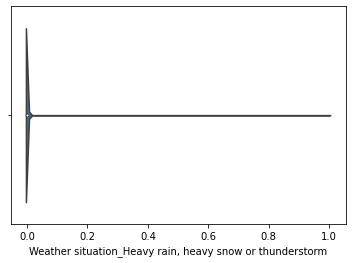

Weather situation_Light snow or light rain


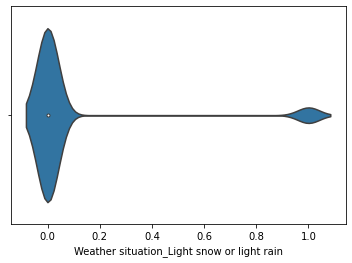

Weather situation_Misty and/or cloudy


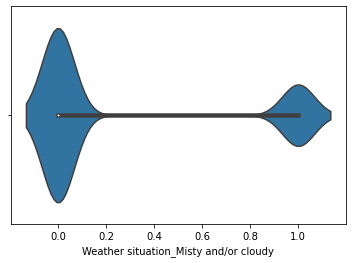

Season_Spring


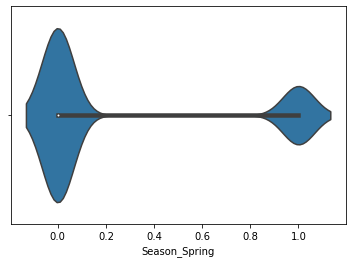

Season_Summer


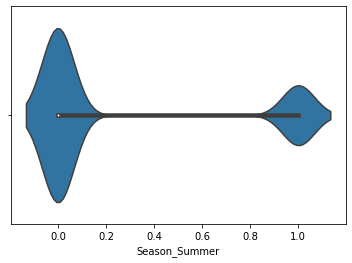

Season_Winter


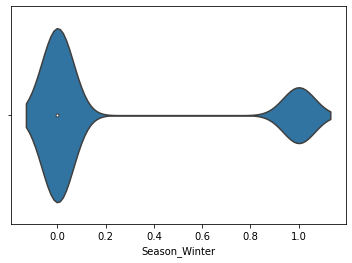

(12165, 17)
Year


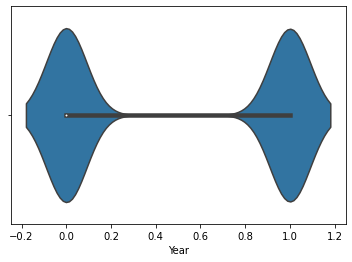

Month


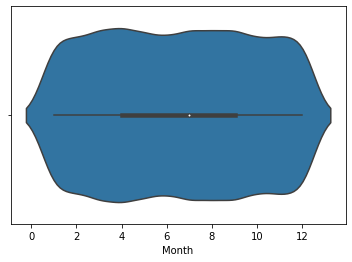

Hour


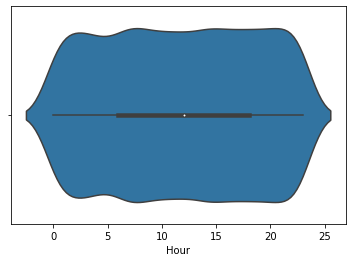

Holiday


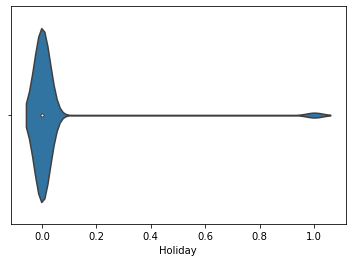

Weekday


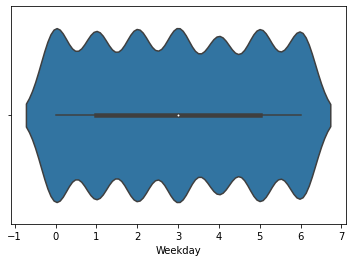

Working day


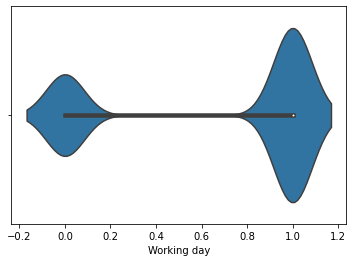

Temperature (normalized)


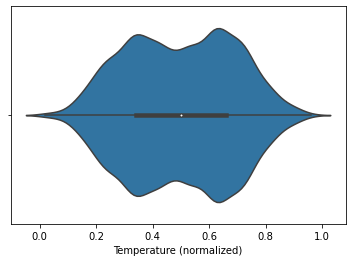

Feels-like temperature (normalized)


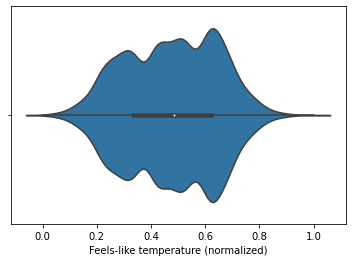

Humidity (normalized)


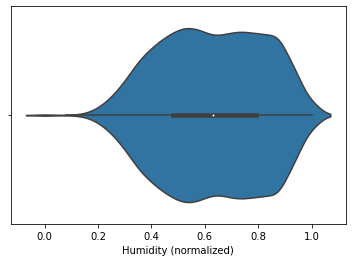

Windspeed


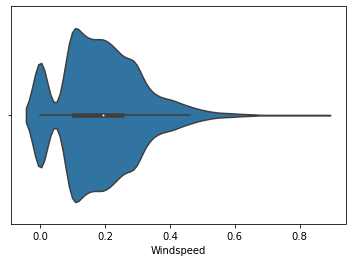

Weather situation_Heavy rain, heavy snow or thunderstorm


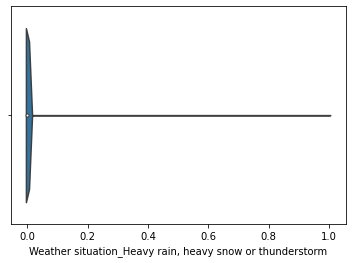

Weather situation_Light snow or light rain


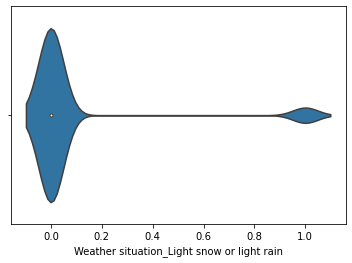

Weather situation_Misty and/or cloudy


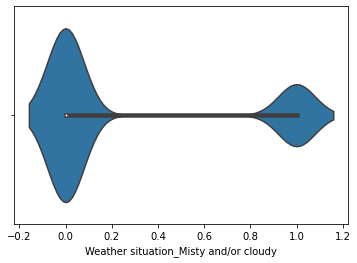

Season_Spring


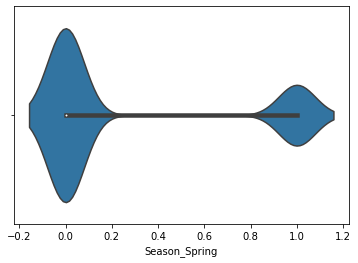

Season_Summer


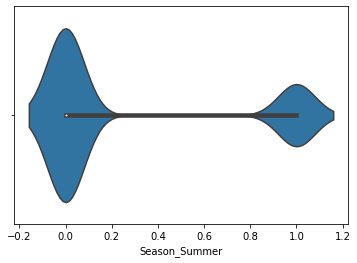

Season_Winter


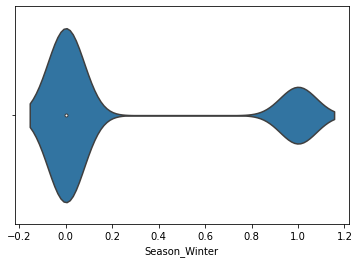

(12165, 17)


In [25]:
#comparing test and train
for col in df.columns:
    print(col)
    sns.violinplot(x=df[col])
    plt.show()
    
print(df.shape)

for col in df_test.columns:
    print(col)
    sns.violinplot(x=df_test[col])
    plt.show()
    
print(df.shape)

### Data cleaning

In [26]:
#print(df.isnull().sum())
#print(df.dtypes)
print(df.shape)
df=df.fillna(df.median())
print(df.shape)
#print(df.isnull().sum())


(12165, 17)
(12165, 17)


### Data exploration after cleaning

Year


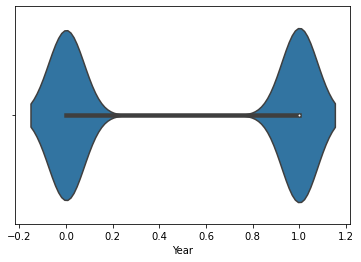

Month


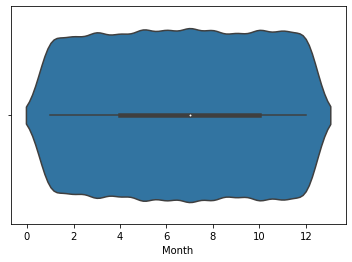

Hour


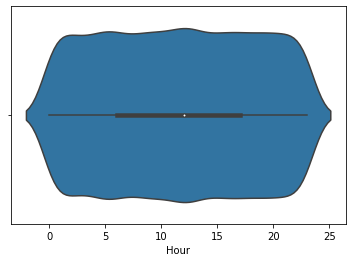

Holiday


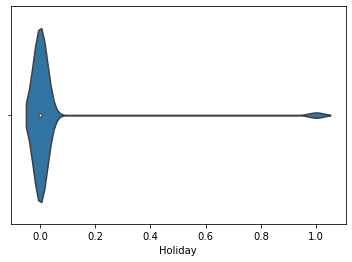

Weekday


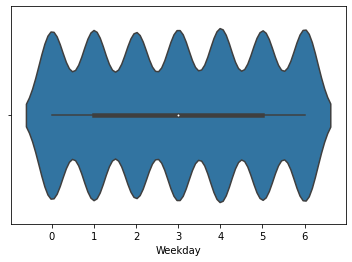

Working day


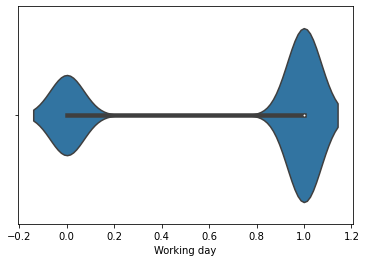

Temperature (normalized)


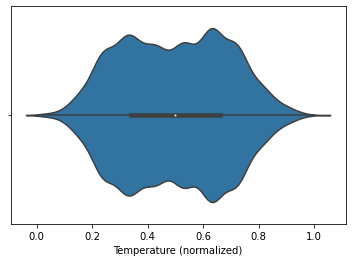

Feels-like temperature (normalized)


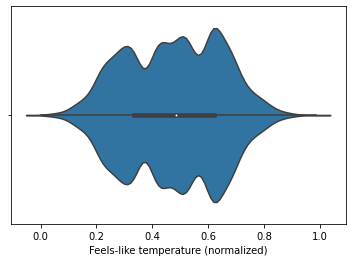

Humidity (normalized)


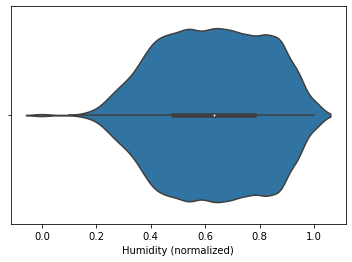

Windspeed


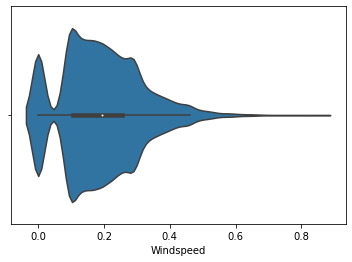

Rental bikes count


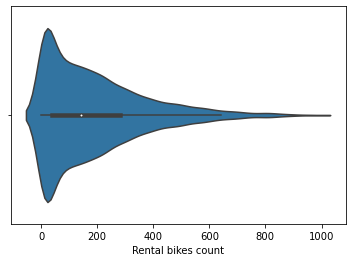

Weather situation_Heavy rain, heavy snow or thunderstorm


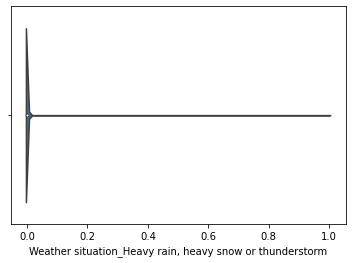

Weather situation_Light snow or light rain


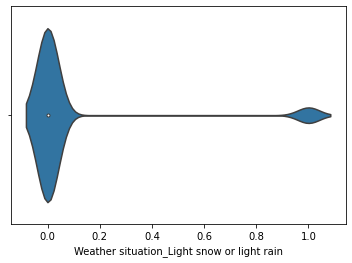

Weather situation_Misty and/or cloudy


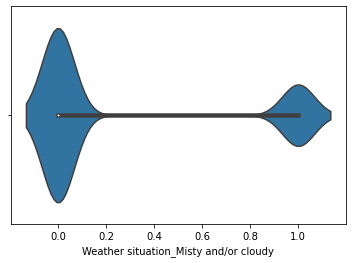

Season_Spring


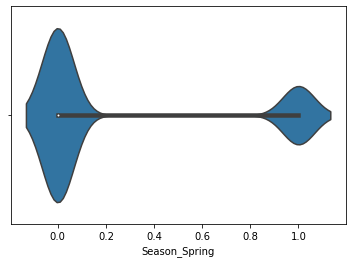

Season_Summer


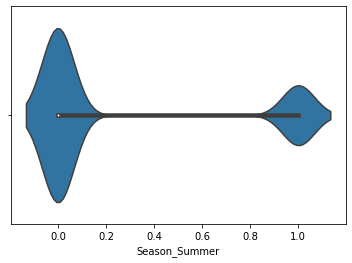

Season_Winter


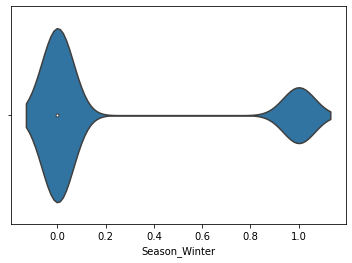

(12165, 17)


In [27]:
for col in df.columns:
    print(col)
    sns.violinplot(x=df[col])
    plt.show()
    
print(df.shape)



### Data preprocessing

In [28]:
y = df['Rental bikes count']
X = df.drop(columns=['Rental bikes count'])

#### Train test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0)

len(X_train)

10948

In [30]:
#used for finding the best features.

forest = RandomForestRegressor(n_estimators=3000, 
                               criterion='squared_error', # Used to be: 'mse'
                               random_state=1,
                               n_jobs=-1,)
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
feat_labels = X.columns
sfm = SelectFromModel(forest, threshold=0.01, prefit=False)
sfm.fit(X_train, y_train)
X_selected = sfm.transform(X_train)
print('Number of features that meet this criterion:', 
      X_selected.shape[1])


indices = sfm.get_support()
selectedFeatures = feat_labels[indices]
print(selectedFeatures)
X_test = X_test[selectedFeatures]
X_train = X_train[selectedFeatures]
#print(X_train)
forest.fit(X_train, y_train)
ysel_pred=forest.predict(X_test)
ysel_pred = np.reshape(ysel_pred, (-1,1))
ysel_pred
print(r2_score(y_test,ysel_pred))

Number of features that meet this criterion: 11
Index(['Year', 'Month', 'Hour', 'Weekday', 'Working day',
       'Temperature (normalized)', 'Feels-like temperature (normalized)',
       'Humidity (normalized)', 'Windspeed',
       'Weather situation_Light snow or light rain', 'Season_Winter'],
      dtype='object')
0.9366106879663967


In [41]:
from sklearn.ensemble import GradientBoostingRegressor
df_test = df_test[selectedFeatures]
gbr = GradientBoostingRegressor(n_estimators=3000, 
                               random_state=1,
                                criterion ='squared_error'
                               )
gbr.fit(X_train, y_train)
gbr_pred=gbr.predict(df_test)

#### Scaling

In [42]:
y_df = pd.DataFrame()
y_df['Rental bikes count'] = gbr_pred
y_df.to_csv('results_rental_reg.csv')

### Modelling

#### Data pipeline with regression model

In [15]:
pipe_for = make_pipeline(PCA(),RandomForestRegressor(n_estimators=3000, 
                               criterion='squared_error',
                               random_state=1, 
                               n_jobs=-1))
pipe_for.get_params()

param_range_n  = [None]
param_range_pca = [None]

param_grid   = [{'randomforestregressor__max_depth': param_range_n, 'pca__n_components': param_range_pca}]

#pipe_for.get_params()

In [16]:
gs = GridSearchCV(estimator=pipe_for, 
                  param_grid=param_grid,  
                  cv=2,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9196641569378932
{'pca__n_components': None, 'randomforestregressor__max_depth': None}


In [17]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
# ... or:
#gs.decision_function(X_train) # (tedious)
print('Test accuracy: %.3f' % gs.score(X_test, y_test))



Test accuracy: 0.934
Test accuracy: 0.934


In [19]:
df_test = df_test[selectedFeatures]
y_test_for_reg= clf.predict(df_test)

y_df = pd.DataFrame()
y_df['Rental bikes count'] = y_test_for_reg
y_df.to_csv('results_rental_reg.csv')

#### Data pipeline with classification model

##### Binning train target values

Can be performed with ex. pandas.qcut or pandas.cut

```python
n_bins = 10
y_train_binned = pd.cut(y_train, n_bins, labels=False) # or
y_train_binned = pd.qcut(y_train, n_bins, labels=False) 
```

In [20]:
n_bins = 15
y_train_binned, bin_name = pd.cut(y_train, n_bins, labels=False, retbins = True)
#print(len(y_train_binned),bin_name)

In [21]:

pipe_for_c = make_pipeline(PCA(),RandomForestClassifier(n_estimators=200, 
                               criterion='entropy', # Used to be: 'mse'
                               random_state=1,
                               n_jobs=-1,))
#print(pipe_for_c.get_params())

param_range_n  = [None]
param_range_pca = [None]

param_grid_c   = [{'randomforestclassifier__max_depth': param_range_n, 'pca__n_components': param_range_pca}]

gs_c = GridSearchCV(estimator=pipe_for_c, 
                  param_grid=param_grid_c,  
                  cv=2,
                  n_jobs=-1)


gs_c = gs_c.fit(X_train, y_train_binned)
print(gs_c.best_score_)
print(gs_c.best_params_)

clf_c = gs_c.best_estimator_
clf_c.fit(X_train, y_train_binned)

y_test_c = clf_c.predict(X_test)

pred_reg_test = [bin_name[int(idx)] for idx in y_test_c]

scr = r2_score(y_test,pred_reg_test)
print(scr)

0.573894775301425
{'pca__n_components': None, 'randomforestclassifier__max_depth': None}
0.7913333199631597


In [22]:
df_test_c = clf_c.predict(df_test)
pred_reg = [bin_name[int(idx)] for idx in df_test_c]

In [23]:
y_df = pd.DataFrame()
y_df['Rental bikes count'] = pred_reg
y_df.to_csv('results_rental_class.csv')

#### Other models used for Kaggle submission

### Final Evaluation

In [ ]:
#used the pipeline for randomforestregressor as kaggle commit

### Kaggle submission

In [ ]:
#file named results_rental_reg.csv